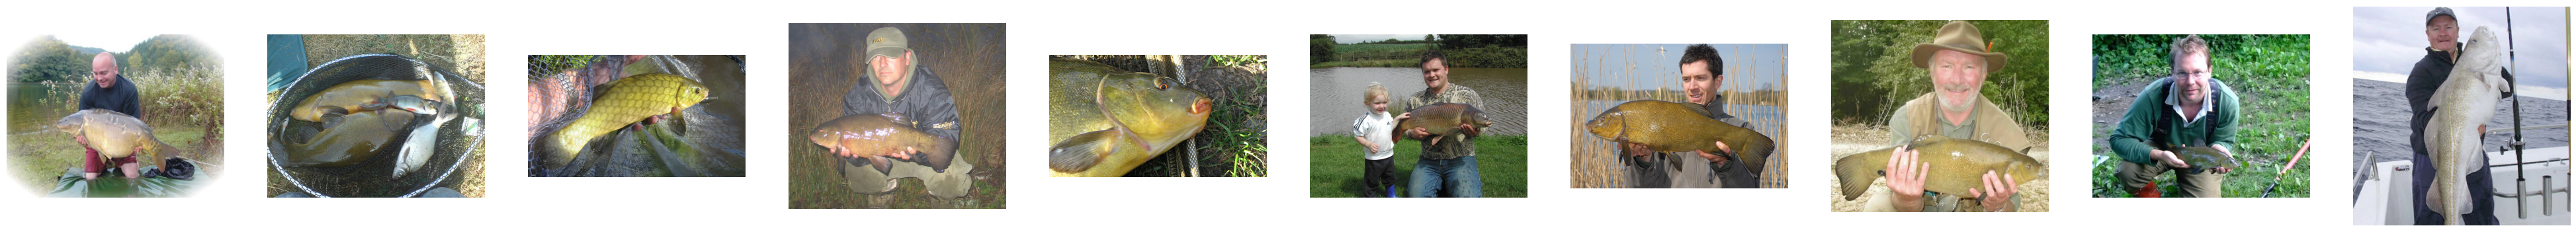

/afs/cs.pitt.edu/usr0/anp407/miniconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/afs/cs.pitt.edu/usr0/anp407/miniconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x1 and 512x1000)

In [4]:
# I want to see the feature from traditional encoder. 
file_path = "/data3/anp407/imagenet_20/train/n01440764"
# get first 10 pictures
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models

def load_image(file_path):
    images = []
    for i, file_name in enumerate(os.listdir(file_path)):
        if i == 10:
            break
        image = cv2.imread(os.path.join(file_path, file_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    return images

def show_images(images):
    fig = plt.figure(figsize=(50, 50))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, 10, i+1)
        ax.imshow(image)
        ax.axis('off')
    plt.show()

images = load_image(file_path)
show_images(images)

# load the model
from torchvision.models import resnet18
model = resnet18(pretrained=True)
model2 = resnet18(pretrained=True)
# I need only the first feature extractor layer
# cut the model to layer1
model_feature =  models.mobilenet_v2().features
model = torch.nn.Sequential(*list(model.children())[:-2])
model2 = torch.nn.Sequential(*list(model2.features())[5:])
model.eval()
model2.eval()
# preprocess the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_images(images):
    images_tensor = []
    for image in images:
        image = Image.fromarray(image)
        image = transform(image)
        images_tensor.append(image)
    return torch.stack(images_tensor)

images_tensor = preprocess_images(images)
# get the feature
with torch.no_grad():
    features = model(images_tensor)
    outputs = []
    for feature in features:
        outputs.append(model2(feature.unsqueeze(0)))
print(outputs)
# visualize the feature
fig = plt.figure(figsize=(50, 50))
for i, feature in enumerate(features):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10+j+1)
        ax.imshow(feature[j,:,:], cmap='gray')
        ax.axis('off')
    if i == 2:
        break
plt.show()
# what if I make some feature to all zeros?
with torch.no_grad():
    # random list for zeroing out, no duplicate
    zero_list = np.random.choice(64, 40, replace=False)
    print(zero_list)
    # for i in range(10):
    #     features[i, zero_list, :, :] = 0
    # run the rest of the model
    output = model2(features)
    
    print(output.shape)

